Importing Libraries

In [2]:
# System related libraries
import os
import datetime
# Handle table-like data and matrices
import numpy as np
import pandas as pd
# keras libraries
import keras
import tensorflow as tf
from keras import optimizers
from keras.layers import *
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, Callback, LearningRateScheduler
# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Visualization libraries
import matplotlib.pyplot as plt
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/
%matplotlib inline

Using TensorFlow backend.


In [3]:
cifar_data = tf.keras.datasets.cifar100

(xTrain, yTrain), (xTest, yTest) = cifar_data.load_data()

169009152/169001437 [==============================] - 12s 0us/step


In [4]:
# Checking the shape of test and train
print("Shape of xTrain: {}".format(xTrain.shape))
print("Shape of yTrain: {}".format(yTrain.shape))
print("Shape of xTest: {}".format(xTest.shape))
print("Shape of yTest: {}".format(yTest.shape))

Shape of xTrain: (50000, 32, 32, 3)
Shape of yTrain: (50000, 1)
Shape of xTest: (10000, 32, 32, 3)
Shape of yTest: (10000, 1)


Before preprocessing the dataset with VGG16 network, checking the data

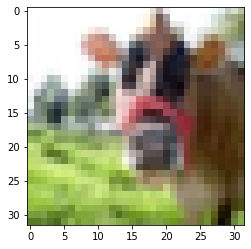

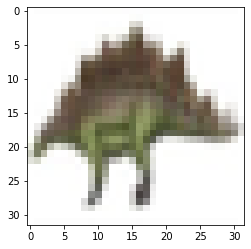

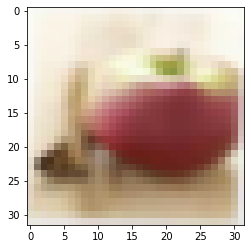

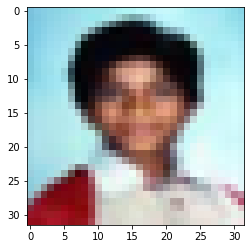

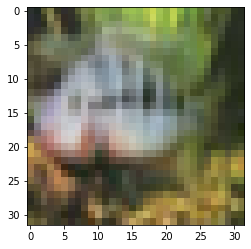

In [5]:
for i in range(5):
    img = xTrain[i].reshape(32,32,3)
    plt.imshow(img)
    plt.show()

In [6]:
# One Hot Encoding
labels_Count = np.unique(yTrain, return_counts=True)
train_labels = pd.DataFrame({'Label':labels_Count[0], 'Count':labels_Count[1]})
train_labels

,Label,Count
0,0,500
1,1,500
2,2,500
3,3,500
4,4,500
...,...,...
95,95,500
96,96,500
97,97,500
98,98,500


Normalizing the dataset

In [0]:

def normalize(xTrain,xTest):
        mean = np.mean(xTrain,axis=(0,1,2,3))
        std = np.std(xTrain, axis=(0, 1, 2, 3))
        xTrain = (xTrain-mean)/(std+1e-7)
        xTest = (xTest-mean)/(std+1e-7)
        return xTrain, xTest

In [0]:
#Convert the inputs to float dtype
xTrain = xTrain.astype('float32')
xTest = xTest.astype('float32')
#Normalize the inputs
xTrain, xTest = normalize(xTrain, xTest)
targetClasses = 100
#Convert the categorical values to One-Hot Encoded
yTrain = to_categorical(yTrain, targetClasses)
yTest = to_categorical(yTest, targetClasses)

In [0]:
def lr_scheduler(epoch):
  return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = LearningRateScheduler(lr_scheduler)

Image augmentation

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(xTrain)

In [0]:
# defining hyperparameters
inputShape = (32,32,3)
weightDecay = 0.0005
learningRate = 0.1
batchSize = 128
lrDecay = 1e-6
epochs = 250
lrDrop = 20

In [0]:
model = keras.models.Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=inputShape, kernel_regularizer=l2(weightDecay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weightDecay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weightDecay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weightDecay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weightDecay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weightDecay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weightDecay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weightDecay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weightDecay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weightDecay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(weightDecay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(weightDecay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(weightDecay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(weightDecay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(targetClasses))
model.add(Activation('softmax'))

In [15]:
#Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 64)       

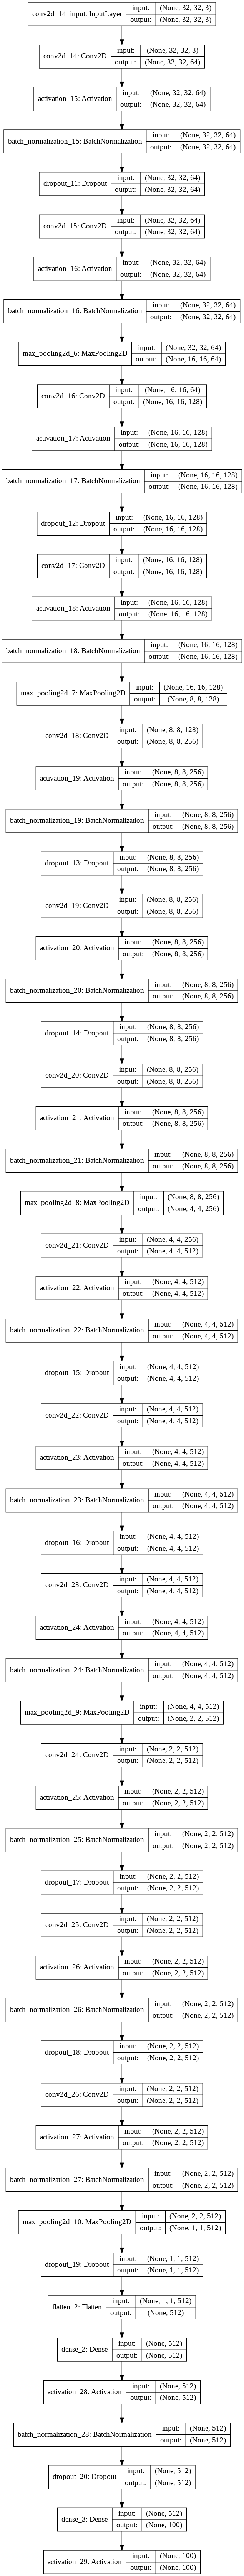

In [16]:
# plot the model
keras.utils.plot_model(model, "vgg16.png", show_shapes=True)

In [0]:
sgd = optimizers.SGD(lr=learningRate, decay=lrDecay, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [0]:
# Create a checkpoint
!mkdir checkpoint

In [0]:
# Setting checkpoint & early stopping
checkpointPath = os.path.join('/content/checkpoint','model_best_weights.{epoch:02d}-{accuracy:.4f}.hdf5')
checkpoint = ModelCheckpoint(
    checkpointPath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

earlyStop = EarlyStopping(monitor='accuracy', patience=5, mode='max')
logDir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboardCallback = keras.callbacks.TensorBoard(log_dir=logDir, histogram_freq=1)
callbacksList = [checkpoint, tensorboardCallback, reduce_lr]

In [0]:
history = model.fit_generator(datagen.flow(xTrain, yTrain,batch_size=batchSize),
                            steps_per_epoch=xTrain.shape[0] // batchSize,
                            epochs=epochs,
                            validation_data=(xTest, yTest),callbacks=callbacksList)

Epoch 1/250
390/390 [==============================] - 4193s 11s/step - loss: 20.0113 - accuracy: 0.0184 - val_loss: 15.2451 - val_accuracy: 0.0088

Epoch 00001: accuracy improved from -inf to 0.01839, saving model to /content/checkpoint/model_best_weights.01-0.0184.hdf5
Epoch 2/250
 43/390 [==>...........................] - ETA: 57:58 - loss: 14.3871 - accuracy: 0.0280

In [0]:
model.save('/content/cifar100vgg.hdf5')

In [0]:
model.save_weights('cifar100vgg.h5')

In [0]:
%tensorboard --logdir logs/fit

In [0]:
!tensorboard dev upload --logdir ./logs \
  --name "VGG16 from Scratch using Keras with CIFAR100" \
  --description "Training results from https://colab.research.google.com/drive/1z683iVLaKZdy1YlQ68ibUffgwkoyg5sS"

In [0]:
score = model.evaluate(xTest,yTest)
print("Test Loss: {}".format(score[0]))
print("Test Accuracy: {}".format(score[1]))

In [0]:
yPred = model.predict_classes(xTest)
yPred = to_categorical(yPred)
print(classification_report(yTest, yPred))